<a href="https://colab.research.google.com/github/dhritiburugupalli/regime-adaptability/blob/main/regime_adaptability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Downloads yahoo finance data, pandas, numpy, skikit-learn, and matplotlib
!pip install yfinance pandas numpy scikit-learn matplotlib

In [5]:
# Imports libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Download SPY Data
ticker = "SPY"
start_date = "2010-01-01"

df = yf.download(ticker, start=start_date)

# flatten MultiIndex columns from yfinance
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print("Columns:", df.columns)

df.head()

/tmp/ipython-input-2870951736.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date)
[*********************100%***********************]  1 of 1 completed

Columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,85.027939,85.072953,83.662450,84.307682,118944600
2010-01-05,85.253021,85.290537,84.667813,84.975426,111579900
2010-01-06,85.313049,85.523124,85.102975,85.170496,116074400
2010-01-07,85.673180,85.778217,84.915407,85.155492,131091100
2010-01-08,85.958305,85.995821,85.275564,85.448122,126402800


In [7]:
# Dataset check
print(df.shape)
print(df.index.min(), "to", df.index.max())
df.isna().sum()

(4054, 5)
2010-01-04 00:00:00 to 2026-02-13 00:00:00


,0
Price,
Close,0
High,0
Low,0
Open,0
Volume,0


In [8]:
# Daily returns
df["Return"] = df["Close"].pct_change()
df[["Close", "Return"]].head()

Price,Close,Return
Date,,
2010-01-04,85.027939,NaN
2010-01-05,85.253021,0.002647
2010-01-06,85.313049,0.000704
2010-01-07,85.673180,0.004221
2010-01-08,85.958305,0.003328


In [9]:
# 20 daily volatility
# Demonstrates the regime through the "chaotic" of market
df["Volatility_20"] = df["Return"].rolling(window=20).std()
df[["Return", "Volatility_20"]].head(25)

Price,Return,Volatility_20
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.002647,NaN
2010-01-06,0.000704,NaN
2010-01-07,0.004221,NaN
2010-01-08,0.003328,NaN
2010-01-11,0.001396,NaN
2010-01-12,-0.009326,NaN
2010-01-13,0.008446,NaN
2010-01-14,0.002705,NaN


In [ ]:
# Clean up the data by cleaning missing rows
df = df.dropna()
print("After dropna:", df.shape)

After dropna: (4034, 7)


In [30]:
# Regime distinguishing
low = df["Volatility_20"].quantile(0.33)
high = df["Volatility_20"].quantile(0.66)

low, high


(np.float64(0.00634445387856706), np.float64(0.009518480736253181))

In [31]:
# regime labeling
def label_regime(vol):
    if vol <= low:
        return "Low"
    elif vol <= high:
        return "Medium"
    else:
        return "High"

df["Regime"] = df["Volatility_20"].apply(label_regime)

df["Regime"].value_counts()

,count
Regime,
High,1392
Medium,1331
Low,1331


In [12]:
# Detecting regime shifts
df["Shift"] = df["Regime"] != df["Regime"].shift(1)

shift_days = df[df["Shift"]]

print("Number of shift days:", len(shift_days))
shift_days.head()


Number of shift days: 292


Price,Close,High,Low,Open,Volume,Return,Volatility_20,Regime,Shift
Date,,,,,,,,,
2010-01-04,85.027939,85.072953,83.662450,84.307682,118944600,NaN,NaN,High,True
2010-03-05,85.718224,85.785745,84.855413,85.057989,176118800,0.014293,0.007058,Medium,True
2010-03-10,86.258392,86.490974,85.838244,85.913269,186088800,0.004456,0.006337,Low,True
2010-04-27,89.257904,91.412504,89.084629,90.892690,355853300,-0.023650,0.008339,Medium,True
2010-04-30,89.506523,91.163915,89.483923,91.065975,270000900,-0.016962,0.009632,High,True


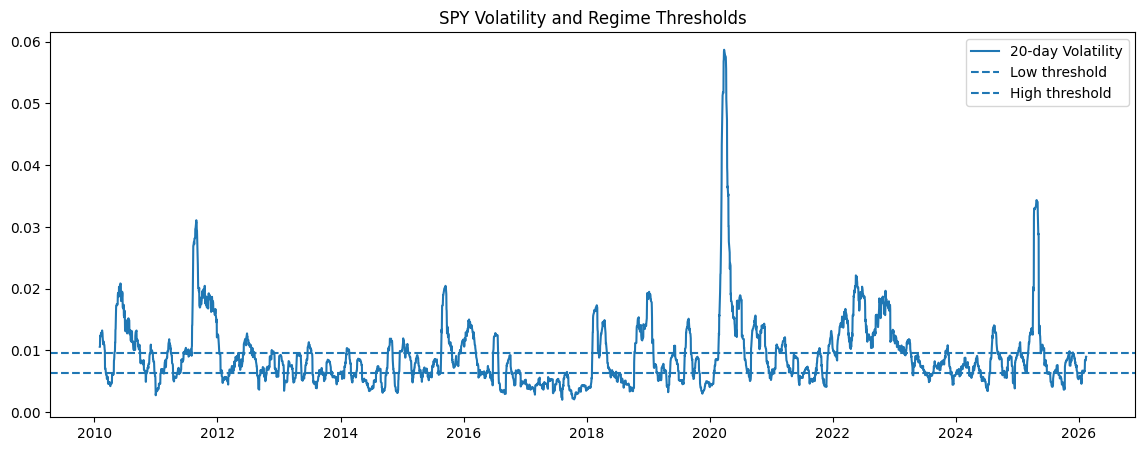

Saved to: /content/drive/MyDrive/ml-regime-adaptability/results/figures/day1_volatility_thresholds.png
Saved data to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_with_regimes.csv


In [28]:
# plotting the 20 day volatility and low and high thresholds
plt.figure(figsize=(14,5))
plt.plot(df.index, df["Volatility_20"], label="20-day Volatility")

# plots the thresholds
plt.axhline(low, linestyle="--", label="Low threshold")
plt.axhline(high, linestyle="--", label="High threshold")

# sets up the graph and displaus it
plt.title("SPY Volatility and Regime Thresholds")
plt.legend()
plt.show()

# saves the graph/data
fig_path = f"{BASE_DIR}/results/figures/day1_volatility_thresholds.png"
plt.savefig(fig_path, dpi=200)
plt.close()
print("Saved to:", fig_path)

# save the processed dataset
csv_path = f"{BASE_DIR}/data/spy_with_regimes.csv"
df.to_csv(csv_path)
print("Saved data to:", csv_path)

In [21]:
# target: next day direction
# astype converts to binary; shift moves values up so
# todays row gets tomorrows return
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# positive -> true -> 1
# negative -> false -> 0
df[["Return", "Target"]].head(10)

Price,Return,Target
Date,,
2010-01-04,NaN,1
2010-01-05,0.002647,1
2010-01-06,0.000704,1
2010-01-07,0.004221,1
2010-01-08,0.003328,1
2010-01-11,0.001396,0
2010-01-12,-0.009326,1
2010-01-13,0.008446,1
2010-01-14,0.002705,0


In [ ]:
# number of positive and negative targets
df["Target"].value_counts()

In [23]:
# features - the signals models use to predict
# 1: changing averages
df["MA_10"] = df["Close"].rolling(10).mean() # over 10 days
df["MA_50"] = df["Close"].rolling(50).mean() # over 50 days

# 2: how much price changed over 10 days (pos = upward trend)
df["Momentum_10"] = df["Close"] - df["Close"].shift(10)

# 3: volatility (short term over 5 days)
df["Volatility_5"] = df["Return"].rolling(5).std()

# 4: volume - trading activity spikes
df["Volume_Change"] = df["Volume"].pct_change()

In [33]:
# clean data (removing NaN values)
# Some rows have missing values as features need past or
# future data
df_clean = df.dropna()
print("Original:", df.shape)
print("Clean:", df_clean.shape)

# Check
df_clean[["Close", "Return", "Target"]].head(5)

Original: (4054, 15)
Clean: (4005, 15)


Price,Close,Return,Target
Date,,,
2010-03-16,87.338768,0.007966,1
2010-03-17,87.856461,0.005927,0
2010-03-18,87.811478,-0.000512,0
2010-03-19,87.366989,-0.005062,1
2010-03-22,87.834061,0.005346,1


In [34]:
# define feature matrix (X: input; Y: output)
feature_cols = [
    "Return",
    "Volatility_20",
    "Volatility_5",
    "MA_10",
    "MA_50",
    "Momentum_10",
    "Volume_Change"
]

X = df_clean[feature_cols]
Y = df_clean["Target"]

# save feature dataset
print(X.shape, Y.shape)

feature_path = f"{BASE_DIR}/data/spy_features_ready.csv"
df_clean.to_csv(feature_path)

print("Saved dataset to:", feature_path)


(4005, 7) (4005,)
Saved dataset to: /content/drive/MyDrive/ml-regime-adaptability/data/spy_features_ready.csv


In [ ]:
# Saves files to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# Organizes the files and creates project folders
import os

BASE_DIR = "/content/drive/MyDrive/ml-regime-adaptability"
folders = [
    "data",
    "results/figures",
    "results/tables",
    "notebooks"
]

for f in folders:
    os.makedirs(os.path.join(BASE_DIR, f), exist_ok=True)

print("Folders created under:", BASE_DIR)

Folders created under: /content/drive/MyDrive/ml-regime-adaptability
